# Project 4: Exploring the India's Copper imports and exports

by Shubham Tiwari

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the India's imports and exports of Copper in year 2021 after the COVID-19:

- How much does the India export and import and is the balance positive (more exports than imports)?
- Which are the main trading partners, i.e. from/to which countries does the India import/export the most?
- Which are the regular customers, i.e. which countries buy copper from the India every month?
- Which countries does the India both import from and export to?


In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import matplotlib
matplotlib.rcParams['axes.grid'] = True # show gridlines by default
%matplotlib inline

from pandas import *

# Getting and preparing the data
The data is obtained from the United Nations Comtrade website(https://comtrade.un.org/data/), by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly
- Periods: 2021
- Reporter: india
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 7402 (Copper; Unrefined, copper anodes for electrolytic refining ) and 7403 (Copper;   refined and copper alloys, unwrought)


Clicking on 'Preview' results in a message that the data exceeds 500 rows. Data was downloaded using the API URL.

In [2]:
URL='http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=2021&r=699&p=all&rg=1%2C2&cc=7402%2C7403&fmt=csv'
Copper = read_csv(URL, dtype={'Commodity Code':str, 'Reporter Code':str})
Copper.head(3)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
0,HS,2021,202101,January 2021,4,0,1,Imports,699,India,...,NaN,NaN,NaN,NaN,484022.0,NaN,3303975,NaN,NaN,0
1,HS,2021,202112,December 2021,4,0,2,Exports,699,India,...,NaN,NaN,NaN,NaN,36.0,NaN,71,NaN,NaN,0
2,HS,2021,202112,December 2021,4,0,2,Exports,699,India,...,NaN,NaN,NaN,NaN,1216440.0,NaN,11206213,NaN,NaN,0


The data is downloaded directly from Comtrade using the "View API Call" URL, modified in two ways:

max=500 is increased to max=5000 to make sure all data is loaded,
&fmt=csv is added at the end to obtain the data in CSV format.

On reading in the data, the commodity code and Reporter Code has to be read as a string, to not lose the leading zero.

In [3]:
Copper.to_csv('copper_commtrade.csv', index=False)

In [4]:
Copper.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Classification          633 non-null    object 
 1   Year                    633 non-null    int64  
 2   Period                  633 non-null    int64  
 3   Period Desc.            633 non-null    object 
 4   Aggregate Level         633 non-null    int64  
 5   Is Leaf Code            633 non-null    int64  
 6   Trade Flow Code         633 non-null    int64  
 7   Trade Flow              633 non-null    object 
 8   Reporter Code           633 non-null    object 
 9   Reporter                633 non-null    object 
 10  Reporter ISO            0 non-null      float64
 11  Partner Code            633 non-null    int64  
 12  Partner                 633 non-null    object 
 13  Partner ISO             0 non-null      float64
 14  2nd Partner Code        0 non-null      fl

The data only covers the months of 2021. Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [5]:
def copperType(code):
    if code == '7402': 
        return 'unrefined'
    if code == '7403':
        return 'refined' 
    return 'unknown'

COMMODITY = 'Copper : Anodes & Alloys'
Copper[COMMODITY] = Copper['Commodity Code'].apply(copperType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
Copper = Copper[headings]
Copper.head()

,Period,Partner,Trade Flow,Copper : Anodes & Alloys,Trade Value (US$)
0,202101,Mozambique,Imports,unrefined,3303975
1,202112,Bangladesh,Exports,unrefined,71
2,202112,China,Exports,unrefined,11206213
3,202102,World,Exports,unrefined,5889
4,202106,World,Imports,unrefined,181749337


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [6]:
Copper = Copper[Copper[PARTNER] != 'World']
Copper.head()

,Period,Partner,Trade Flow,Copper : Anodes & Alloys,Trade Value (US$)
0,202101,Mozambique,Imports,unrefined,3303975
1,202112,Bangladesh,Exports,unrefined,71
2,202112,China,Exports,unrefined,11206213
5,202101,South Africa,Imports,unrefined,89488687
6,202107,United Rep. of Tanzania,Imports,unrefined,95858838


# Total trade flow

To answer the first question, 'how much does the India export and import and is the balance positive (more exports than imports)?', the dataframe is split into two groups: exports from the India and imports into the India. The trade values within each group are summed up to get the total trading.

In [7]:
grouped = Copper.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports    1380070737
Imports    2942800730
Name: Trade Value (US$), dtype: int64

This shows a trade surplus of over 100 million dollars.

# Main trade partners

To address the second question, 'Which are the main trading partners, i.e. from/to which countries does the India import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [8]:
imports = Copper[Copper[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('The India imports from', len(grouped), 'countries.')
print('The 10 biggest exporters to the India are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head(10)

The India imports from 43 countries.
The 10 biggest exporters to the India are:


Partner
Japan                      1103342960
United Rep. of Tanzania     808642177
South Africa                699202806
Mozambique                  184998930
Philippines                  42218039
United Arab Emirates         32094000
Namibia                      23339575
Thailand                     10395623
Italy                         9700769
Malaysia                      6640690
Name: Trade Value (US$), dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

<AxesSubplot:ylabel='Partner'>

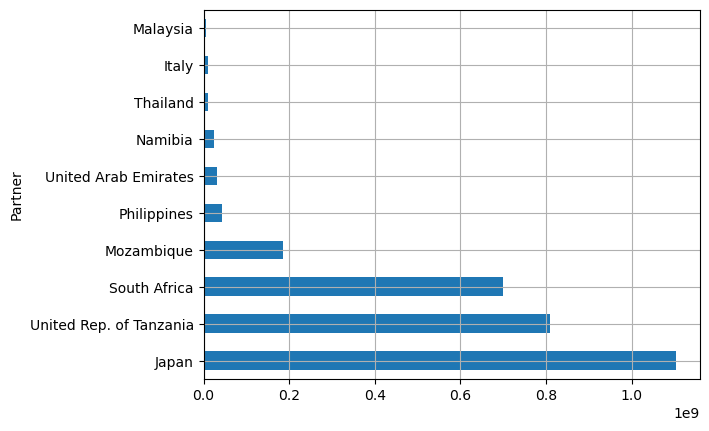

In [9]:
totalImports.head(10).plot(kind='barh')

In [10]:
exports = Copper[Copper[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('The India exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the India are:')
totalExports = grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False)
totalExports.head(10)

The India exports to 66 countries.
The 5 biggest importers from the India are:


Partner
China                       1263541237
Singapore                     69026928
Rep. of Korea                 28726317
Bangladesh                     6990689
Other Asia, nes                2066998
Spain                          1782449
Sri Lanka                      1125869
United States of America       1109824
Thailand                        789733
Germany                         684702
Name: Trade Value (US$), dtype: int64

<AxesSubplot:ylabel='Partner'>

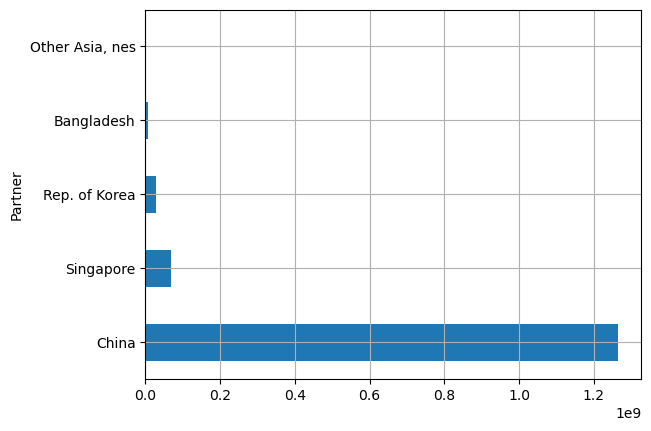

In [11]:
totalExports.head(5).plot(kind='barh')

# Regular importers

Given that there are two commodities, the third question, 'Which are the regular customers, i.e. which countries buy Copper from the India every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [12]:
def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 202101) & (regular[COMMODITY] == 'refined')]

,Period,Partner,Trade Flow,Copper : Anodes & Alloys,Trade Value (US$)
52,202101,Saudi Arabia,Exports,refined,7672
589,202101,Sri Lanka,Exports,refined,42331


the total Copper exports are due to these regular customers.

In [13]:
regular[VALUE].sum() / exports[VALUE].sum()

0.0010711530651055317

# Bi-directional trade

To address the fourth question, 'Which countries does the India both import from and export to?', a pivot table is used to list the total export and import value for each country. 

In [14]:
countries = pivot_table(Copper, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
Angola,1703.0,NaN
Australia,6798.0,NaN
Austria,NaN,4007017.0
Bahrain,5850.0,425887.0
Bangladesh,6990689.0,93851.0


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the India.

In [15]:
countries.dropna()

Trade Flow,Exports,Imports
Partner,,
Bahrain,5.850000e+03,4.258870e+05
Bangladesh,6.990689e+06,9.385100e+04
Belgium,5.334040e+05,4.249920e+05
Canada,7.510000e+03,7.828300e+04
China,1.263541e+09,2.158292e+06
"China, Hong Kong SAR",1.603210e+05,1.080360e+05
France,3.762630e+05,8.116300e+04
Germany,6.847020e+05,2.860675e+06
Indonesia,5.140000e+02,1.465216e+06


# Conclusions
The Copper trade of the India from Year 2021 was analysed in terms of which countries the India mostly depends on for income (exports) and goods (imports). Over the period, the India had a trade surplus of over 100 million US dollars.

China is the main partner.
Japan imported from the India almost the same as china in value.

The India exported to over 66 countries during the period, but only imported from 43 countries, the main ones (top five by trade value) being geographically close. Japan and South AF=frica are the main importers that are not also main exporters.

The India is heavily dependent on its regular customers, the 2 countries that buy all types of copper every month.

The India has bi-directional trade (i.e. both exports and imports) with 33 countries.